<a href="https://colab.research.google.com/github/phytometrics/plant_phenotyping_python/blob/main/notebooks/growliflower.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# カリフラワーインスタンスセグメンテーションモデルの作成

## ライセンス
- GrowliFlowerデータセット
    - http://rs.ipb.uni-bonn.de/data/growliflower/
    - https://phenoroam.phenorob.de/geonetwork/srv/eng/catalog.search#/metadata/cb328232-31f5-4b84-a929-8e1ee551d66a
    - 
## 解説

## 備考
detectron2の設定ファイルは、YAML/YACS形式の記述に加え、LazyConfigsを用いたPython辞書型での管理方法もあります。設定項目の柔軟性を鑑み、2023年12月現在では後者の使用が推奨されています。しかし、このノートブックでは公式サンプルに追従し、前者の方法を採用します。

参考リンク：

https://detectron2.readthedocs.io/en/latest/tutorials/configs.html

https://detectron2.readthedocs.io/en/latest/tutorials/lazyconfigs.html

## 環境構築

In [2]:
import os
import cv2
import json
import numpy as np
import matplotlib.pyplot as plt

In [3]:
#https://phenoroam.phenorob.de/geonetwork/srv/eng/catalog.search#/metadata/cb328232-31f5-4b84-a929-8e1ee551d66a
!wget https://phenoroam.phenorob.de/geonetwork/srv/api/records/cb328232-31f5-4b84-a929-8e1ee551d66a/attachments/79798936-GrowliFlowerL.zip
!unzip -q /content/79798936-GrowliFlowerL.zip

--2023-12-18 13:28:44--  https://phenoroam.phenorob.de/geonetwork/srv/api/records/cb328232-31f5-4b84-a929-8e1ee551d66a/attachments/79798936-GrowliFlowerL.zip
Resolving phenoroam.phenorob.de (phenoroam.phenorob.de)... 131.220.186.32
Connecting to phenoroam.phenorob.de (phenoroam.phenorob.de)|131.220.186.32|:443... connected.
HTTP request sent, awaiting response... 200 
Length: 79798936 (76M) [application/zip]
Saving to: ‘79798936-GrowliFlowerL.zip’

79798936-GrowliFlow 100%[===================>]  76.10M  17.2MB/s    in 5.1s    

2023-12-18 13:28:50 (15.0 MB/s) - ‘79798936-GrowliFlowerL.zip’ saved [79798936/79798936]



In [4]:
# installation procedure from official repo.
# https://colab.research.google.com/drive/16jcaJoc6bCFAQ96jDe2HwtXj7BMD_-m5
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install -q {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 2.6 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
Cloning into 'detectron2'...
remote: Enumerating objects: 15292, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 15292 (delta 3), reused 6 (delta 1), pack-reused 15275
Receiving objects: 100% (15292/15292), 6.18 MiB | 19.35 MiB/s, done.
Resolving deltas: 100% (11118/11118), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 879.3 kB/s eta 0:00:00
  P

In [5]:
import torch
import detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
torch:  2.1 ; cuda:  cu121
detectron2: 0.6


## detectron2に適合するデータセットを用意し、アノテーションを登録する

Detectron2 requires datasets in a specific format. You need to convert your dataset into a list of dictionaries, with each dictionary representing an image and its associated annotations. A typical entry may look like this:

```python
{
    "file_name": "path/to/image.jpg",
    "height": 1024,
    "width": 768,
    "image_id": 12345,
    "annotations": [
        {
            "bbox": [x, y, width, height],
            "bbox_mode": BoxMode.XYWH_ABS,
            "segmentation": [[x1, y1, x2, y2, ...]],
            "category_id": 0,
        },
        ...
    ]
}

# register
from detectron2.data import DatasetCatalog, MetadataCatalog

def get_my_dataset_dicts():
    # Your data loading logic here
    pass

for d in ["train", "val"]:
    DatasetCatalog.register("my_dataset_" + d, lambda d=d: get_my_dataset_dicts(d))
    MetadataCatalog.get("my_dataset_" + d).set(thing_classes=["class1", "class2", ...])
```

In [6]:
from detectron2.structures import BoxMode
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.utils.visualizer import Visualizer
import random
from functools import partial

def bgrmask2gray(image, background_color = [168, 38, 62]):
    # background color is unique to the dataset
    unique_colors = np.unique(image.reshape(-1, image.shape[2]), axis=0)
    # Create a mask for the background
    background_mask = np.all(image == background_color, axis=-1)
    # # Convert the background to 0
    grayscale_image = np.zeros(image.shape[:2], dtype=np.uint8)
    grayscale_image[~background_mask] = 255  # Set non-background to 255 temporarily

    # Find unique colors (excluding the background)
    unique_colors = np.unique(image.reshape(-1, image.shape[2]), axis=0)
    unique_colors = unique_colors[~np.all(unique_colors == background_color, axis=1)]
    # Assign unique grayscale values (1, 2, ... n) to each unique color
    for i, color in enumerate(unique_colors, start=1):
        color_mask = np.all(image == color, axis=-1)
        grayscale_image[color_mask] = i
    return grayscale_image


In [8]:
from multiprocessing import Pool
import pickle

def process_image(file, img_dir, mask_dir):
    image_path = os.path.join(img_dir, file)
    basename = os.path.splitext(file)[0]
    mask_path = os.path.join(mask_dir, basename + "_Label_maskPlants.png")

    if not os.path.isfile(mask_path):
        return None

    mask = cv2.imread(mask_path)
    mask = bgrmask2gray(mask)

    record = {"file_name": image_path, "image_id": image_path, "height": mask.shape[0], "width": mask.shape[1]}
    objs = []
    instances = np.unique(mask)
    for instance in instances:
        if instance == 0:  # Skip background for maskPlants
            continue
        binary_mask = np.uint8(mask == instance)
        contours, _ = cv2.findContours(binary_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        polygons = []
        for contour in contours:
            # Approximate contour to polygon
            epsilon = 0.005 * cv2.arcLength(contour, True)
            approx = cv2.approxPolyDP(contour, epsilon, True)
            # Flatten the polygon coordinates and add to list
            poly = approx.flatten().tolist()
            if len(poly) <=4:
                # if less than 2 coords
                continue
            polygons.append(contour.flatten().tolist())
        if len(polygons) ==0:
            continue

        # Initialize min and max values
        min_x, max_x = float('inf'), float('-inf')
        min_y, max_y = float('inf'), float('-inf')

        # Iterate through each polygon
        for polygon in polygons:
            # Iterate through points in the polygon
            for i in range(0, len(polygon), 2):
                x, y = polygon[i], polygon[i + 1]
                min_x, max_x = min(min_x, x), max(max_x, x)
                min_y, max_y = min(min_y, y), max(max_y, y)

        obj = {
            "bbox": [min_x, min_y, max_x, max_y],
            "bbox_mode": BoxMode.XYXY_ABS,
            "segmentation": polygons,
            "category_id": 0
        }
        objs.append(obj)
    record["annotations"] = objs
    return record

def get_GrowliFlowerDataset_multiprocess(img_dir, mask_dir):
    files = sorted(os.listdir(img_dir))

    # Create a pool of processes
    with Pool() as pool:
        # Map the process_image function to each file
        results = pool.starmap(process_image, [(file, img_dir, mask_dir) for file in files])

    # Filter out None results and return
    return [result for result in results if result is not None]

dataset_dictlist = get_GrowliFlowerDataset_multiprocess(img_dir = "/content/GrowliFlowerL/images/Train",
                                 mask_dir = "/content/GrowliFlowerL/labels/Train/maskPlants")
with open('growliflower_train.pkl', 'wb') as f:
    pickle.dump(dataset_dictlist, f)

dataset_dictlist = get_GrowliFlowerDataset_multiprocess(img_dir = "/content/GrowliFlowerL/images/Val",
                                 mask_dir = "/content/GrowliFlowerL/labels/Val/maskPlants")
with open('growliflower_val.pkl', 'wb') as f:
    pickle.dump(dataset_dictlist, f)

dataset_dictlist = get_GrowliFlowerDataset_multiprocess(img_dir = "/content/GrowliFlowerL/images/Test",
                                 mask_dir = "/content/GrowliFlowerL/labels/Test/maskPlants")
with open('growliflower_test.pkl', 'wb') as f:
    pickle.dump(dataset_dictlist, f)

MetadataCatalog.get("GrowliFlower_train").set(thing_classes=["cauliflower"])
metadata = MetadataCatalog.get("GrowliFlower_train")

In [14]:
def load_GrowliFlower_pickle(subset):
    with open(f'growliflower_{subset}.pkl', 'rb') as f:
        return pickle.load(f)

for d in ["train", "val", "test"]:
    DatasetCatalog.register("GrowliFlower_" + d, lambda d=d: load_GrowliFlower_pickle(d))
    MetadataCatalog.get("GrowliFlower_" + d).set(thing_classes=["cauliflower"])
metadata = MetadataCatalog.get("GrowliFlower_train")

/content/GrowliFlowerL/images/Train/patch_2020_08_12_29629.jpg


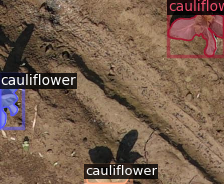

/content/GrowliFlowerL/images/Train/patch_2020_08_12_38817.jpg


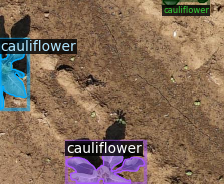

/content/GrowliFlowerL/images/Train/patch_2020_08_12_100033.jpg


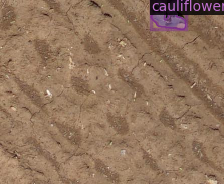

In [10]:
from google.colab.patches import cv2_imshow

dataset = load_GrowliFlower_pickle("train")

for d in random.sample(dataset, 3):
    print(d["file_name"])
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(out.get_image()[:, :, ::-1])

## configuration

In [15]:
# validation training issue
# https://github.com/facebookresearch/detectron2/issues/4368
#model zoo
#https://github.com/facebookresearch/detectron2/blob/main/MODEL_ZOO.md
from detectron2.config import get_cfg
from detectron2.engine import DefaultTrainer
from detectron2 import model_zoo

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("GrowliFlower_train",)
cfg.DATASETS.TEST = ("GrowliFlower_test",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 1000    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # The "RoIHead batch size". 128 is faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[12/18 14:13:30 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


[12/18 14:13:31 d2.engine.train_loop]: Starting training from iteration 0
[12/18 14:13:40 d2.utils.events]:  eta: 0:07:32  iter: 19  total_loss: 1.712  loss_cls: 0.6927  loss_box_reg: 0.2726  loss_mask: 0.6919  loss_rpn_cls: 0.03523  loss_rpn_loc: 0.01449    time: 0.4589  last_time: 0.4672  data_time: 0.0278  last_data_time: 0.0058   lr: 4.9953e-06  max_mem: 2762M
[12/18 14:13:50 d2.utils.events]:  eta: 0:07:25  iter: 39  total_loss: 1.669  loss_cls: 0.5966  loss_box_reg: 0.3131  loss_mask: 0.6889  loss_rpn_cls: 0.03727  loss_rpn_loc: 0.01845    time: 0.4635  last_time: 0.4024  data_time: 0.0093  last_data_time: 0.0143   lr: 9.9902e-06  max_mem: 2762M
[12/18 14:13:59 d2.utils.events]:  eta: 0:07:14  iter: 59  total_loss: 1.468  loss_cls: 0.4275  loss_box_reg: 0.2914  loss_mask: 0.6825  loss_rpn_cls: 0.03139  loss_rpn_loc: 0.01524    time: 0.4609  last_time: 0.4788  data_time: 0.0115  last_data_time: 0.0075   lr: 1.4985e-05  max_mem: 2762M
[12/18 14:14:08 d2.utils.events]:  eta: 0:07:03

[12/18 14:21:55 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


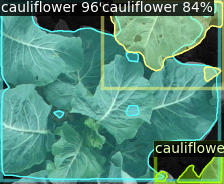

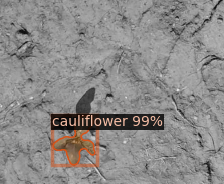

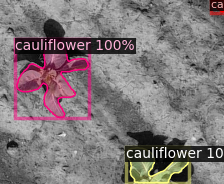

In [16]:
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import ColorMode

# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

dataset_dicts = load_GrowliFlower_pickle("val")

for d in random.sample(dataset_dicts, 3):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=metadata,
                   scale=0.5,
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])